In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns

In [2]:
#df = pd.read_csv("data/testdata_000000000000.csv", index_col="clusterid",dtype=np.uint32)
df = pd.concat([pd.read_csv(f,dtype=np.uint32,index_col="clusterid") for f in glob.glob('data/testdata_*.csv')])

In [3]:
df.head(10)

,out_degree,in_degree,total_degree
clusterid,,,
20,38887182,23566625,62453807
121,11096220,19351778,30447998
991,15621598,14212803,29834401
803899,11724699,12809421,24534120
5658,1180037,15362480,16542517
23206283,4013243,11619790,15633033
55,7607983,7386209,14994192
8,10583127,3732905,14316032
2959,8423944,5870729,14294673


In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 76742089 entries, 20 to 822614669
Data columns (total 3 columns):
 #   Column        Non-Null Count     Dtype 
---  ------        --------------     ----- 
 0   out_degree    76742089 non-null  uint32
 1   in_degree     76742089 non-null  uint32
 2   total_degree  76742089 non-null  uint32
dtypes: uint32(3)
memory usage: 1.4 GB


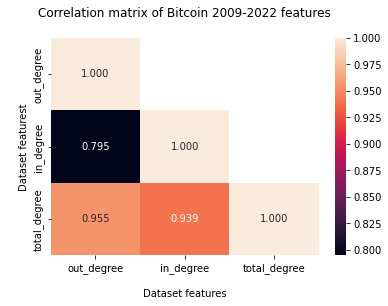

In [5]:
corr = df.corr().abs()

hm = sns.heatmap(corr, annot = True, fmt="0.3f",  mask = ~np.tril(np.ones(corr.shape)).astype(bool))

hm.set(xlabel='\nDataset features', ylabel='\nDataset featurest', title = "Correlation matrix of Bitcoin 2009-2022 features\n")

plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Correlation >=0.8 can 'confuse the model' and were extracted
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.8)]
print(f"Removing strong correlated columns: {to_drop}")

df.drop(columns=to_drop, axis=1,inplace=True)


#df[df.columns] = StandardScaler().fit_transform(df[df.columns])

display(df.head())
display(df.info(show_counts=True))


Removing strong correlated columns: ['total_degree']


,out_degree,in_degree
clusterid,,
20,38887182,23566625
121,11096220,19351778
991,15621598,14212803
803899,11724699,12809421
5658,1180037,15362480


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 76742089 entries, 20 to 822614669
Data columns (total 2 columns):
 #   Column      Non-Null Count     Dtype 
---  ------      --------------     ----- 
 0   out_degree  76742089 non-null  uint32
 1   in_degree   76742089 non-null  uint32
dtypes: uint32(2)
memory usage: 1.1 GB


None

In [7]:
sample = df.sample(10000,random_state=42)

In [8]:
# #############################################################################
# Compute DBSCAN
from sklearn import metrics
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=100).fit(sample)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

sample["labels"] = labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
#print(
#    "Adjusted Mutual Information: %0.3f"
#    % metrics.adjusted_mutual_info_score(labels_true, labels)
#)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(sample, labels))

Estimated number of clusters: 13
Estimated number of noise points: 3955
Silhouette Coefficient: 0.359


In [14]:
sample.labels.value_counts()

-1     3955
 0     2721
 1     1554
 2      247
 3      228
 4      203
 5      199
 10     151
 7      141
 9      131
 11     130
 6      123
 12     117
 8      100
Name: labels, dtype: int64

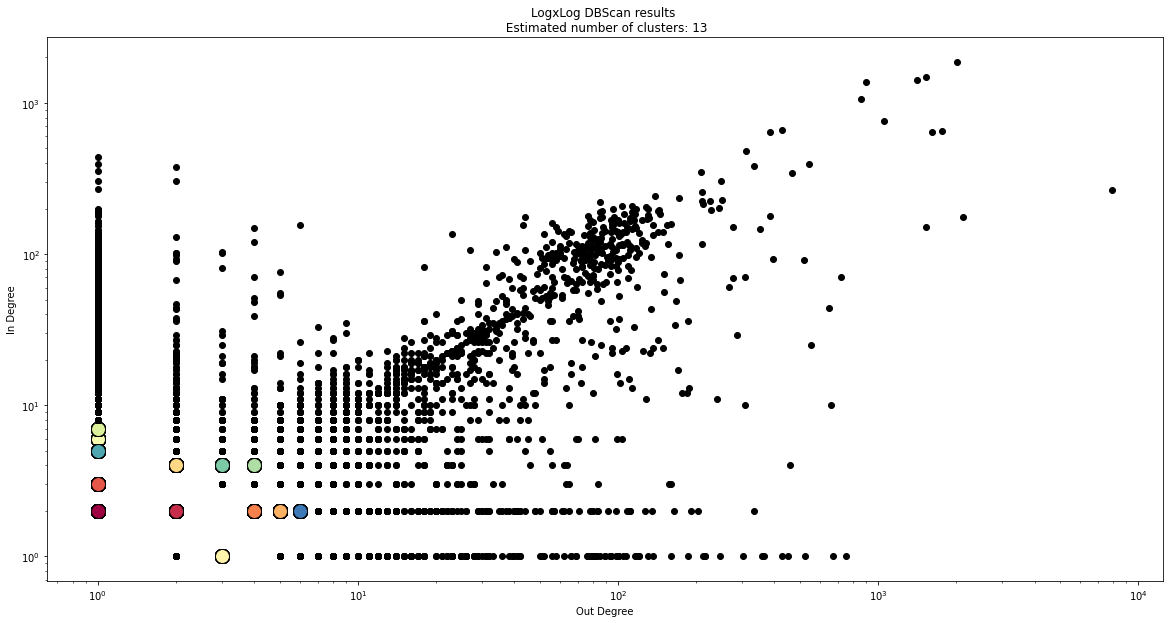

In [10]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure(figsize=(20,10))
ax = plt.gca()

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = sample[class_member_mask & core_samples_mask]
    plt.plot(xy.out_degree,xy.in_degree,"o",markerfacecolor=tuple(col),markeredgecolor="k",markersize=14)

    xy = sample[class_member_mask & ~core_samples_mask]
    plt.plot(xy.out_degree, xy.in_degree,"o",markerfacecolor=tuple(col),markeredgecolor="k",markersize=6)

ax.set_yscale('log')
ax.set_xscale('log')

plt.title("LogxLog DBScan results \n Estimated number of clusters: %d" % n_clusters_)

plt.xlabel("Out Degree") # X-axis label
plt.ylabel("In Degree") # Y-axis label
plt.show()

In [11]:
sample.head()

,out_degree,in_degree,labels
clusterid,,,
212297077,5,5,-1
616998708,1,2,0
702391028,1,2,0
80712892,1,19,-1
814171283,1,2,0
